In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

class Dense:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / (input_dim + output_dim)) # ensure tthe variance
        self.bias = np.zeros((1, output_dim))
        self.input = None
        self.output = None
        
    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        return self.output
    
    def backward(self, grad_output, learning_rate):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)
        
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input

In [67]:
class BatchNorm:
    def __init__(self, input_dim, epsilon=1e-8, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))
        self.momentum = 0.9
        self.input = None
        self.normalized = None
        self.std = None
        self.var = None
        self.mean = None
        
    def forward(self, input_data, training=True):
        self.input = input_data
        
        if training:
            self.mean = np.mean(input_data, axis=0, keepdims=True)
            self.var = np.var(input_data, axis=0, keepdims=True)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.mean = self.running_mean
            self.var = self.running_var
        
        self.std = np.sqrt(self.var + self.epsilon)
        self.normalized = (input_data - self.mean) / self.std
        
        return self.gamma * self.normalized + self.beta
    
    def backward(self, grad_output, learning_rate):
        batch_size = grad_output.shape[0]
        
        grad_gamma = np.sum(grad_output * self.normalized, axis=0, keepdims=True)
        grad_beta = np.sum(grad_output, axis=0, keepdims=True)
        
        grad_normalized = grad_output * self.gamma
        grad_var = -0.5 * np.sum(grad_normalized * (self.input - self.mean) / (self.std ** 3), axis=0, keepdims=True)
        grad_mean = -np.sum(grad_normalized / self.std, axis=0, keepdims=True) - 2 * grad_var * np.mean(self.input - self.mean, axis=0, keepdims=True)
        grad_input = grad_normalized / self.std + 2 * grad_var * (self.input - self.mean) / batch_size + grad_mean / batch_size
        
        self.gamma -= learning_rate * grad_gamma
        self.beta -= learning_rate * grad_beta
        
        return grad_input

In [68]:
class ReLU:
    def __init__(self):
        self.input = None
        
    def forward(self, input_data):
        self.input = input_data
        return np.maximum(0, input_data)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Dropout:
    def __init__(self, drop_rate=0.5):
        self.drop_rate = drop_rate
        self.mask = None
        
    def forward(self, input_data, training=True):
        if training:
            self.mask = np.random.binomial(1, 1-self.drop_rate, size=input_data.shape) / (1-self.drop_rate)
            return input_data * self.mask
        return input_data
    
    def backward(self, grad_output):
        return grad_output * self.mask

In [69]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
        
    def update(self, params, grads):
        if not self.m:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
        
        self.t += 1
        
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            
            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [70]:
class Softmax:
    def __init__(self):
        self.output = None
        
    def forward(self, input_data):
        exp = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)

In [71]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, num_classes,learning_rate=0.001):
        self.layers = []
        layer_sizes = [input_size] + hidden_sizes + [num_classes]
        self.learning_rate = learning_rate
        
        # Create the network architecture
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Dense(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Don't add these layers after the last Dense layer
                self.layers.append(BatchNorm(layer_sizes[i+1]))
                self.layers.append(ReLU())
                self.layers.append(Dropout(0.3))
        
        self.layers.append(Softmax())
        self.optimizer = Adam(learning_rate=learning_rate)
    
    def forward(self, x, training=True):
        output = x
        for layer in self.layers:
            if isinstance(layer, (BatchNorm, Dropout)):
                output = layer.forward(output, training)
            else:
                output = layer.forward(output)
        return output
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            if isinstance(layer, (Dense, BatchNorm)):
                grad_output = layer.backward(grad_output, self.optimizer.learning_rate)
            else:
                grad_output = layer.backward(grad_output)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):
    # Convert labels to one-hot encoding
        enc = OneHotEncoder(sparse_output=False)  # Changed from sparse=False to sparse_output=False
        y_train_oh = enc.fit_transform(y_train.reshape(-1, 1))
        y_val_oh = enc.transform(y_val.reshape(-1, 1))
        
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        val_f1s = []
        
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
    
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train = X_train[indices]
            y_train_oh = y_train_oh[indices]
            
            epoch_loss = 0
            correct_predictions = 0
            
            # Training
            for batch in tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{epochs}'):
                start_idx = batch * batch_size
                end_idx = start_idx + batch_size
                
                X_batch = X_train[start_idx:end_idx]
                y_batch = y_train_oh[start_idx:end_idx]
                
                # Forward pass
                output = self.forward(X_batch, training=True)
                predictions = np.argmax(output, axis=1)
                correct_predictions += np.sum(predictions == np.argmax(y_batch, axis=1))
                
                # Calculate loss
                loss = -np.mean(np.sum(y_batch * np.log(output + 1e-8), axis=1))
                epoch_loss += loss
                
                # Backward pass
                grad_output = output - y_batch
                self.backward(grad_output)
            
            # Calculate training metrics
            train_loss = epoch_loss / n_batches
            train_acc = correct_predictions / n_samples
            
            # Validation metrics
            val_output = self.forward(X_val, training=False)
            val_loss = -np.mean(np.sum(y_val_oh * np.log(val_output + 1e-8), axis=1))
            val_pred = np.argmax(val_output, axis=1)
            val_acc = np.mean(val_pred == y_val)
            val_f1 = f1_score(y_val, val_pred, average='macro')
            
            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)
            
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            print(f'Val Macro-F1: {val_f1:.4f}\n')
        
        return train_losses, val_losses, train_accs, val_accs, val_f1s

In [72]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten
    ])
    
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    x_train = []
    y_train = []
    for data in train_loader:
        x_train.append(data[0].numpy())
        y_train.append(data[1].numpy())
    
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)
    
    x_val = []
    y_val = []
    for data in test_loader:
        x_val.append(data[0].numpy())
        y_val.append(data[1].numpy())
    
    x_val = np.concatenate(x_val)
    y_val = np.concatenate(y_val)
    
    return x_train, y_train, x_val, y_val

In [73]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, val_f1s):
    epochs = len(train_losses)
    
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracies
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Plot F1 scores
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), val_f1s, label='Validation Macro-F1')
    plt.xlabel('Epoch')
    plt.ylabel('Macro-F1 Score')
    plt.legend()
    plt.title('Validation Macro-F1 Score')
    
    plt.tight_layout()
    plt.show()

Loading data...
Initializing model...
Training model...


Epoch 1/15: 100%|██████████| 937/937 [00:23<00:00, 39.46it/s]


Epoch 1/15:
Train Loss: 1.2148, Train Accuracy: 0.6173
Val Loss: 0.6269, Val Accuracy: 0.7937
Val Macro-F1: 0.7885



Epoch 2/15: 100%|██████████| 937/937 [00:32<00:00, 28.53it/s]


Epoch 2/15:
Train Loss: 0.7501, Train Accuracy: 0.7655
Val Loss: 0.5196, Val Accuracy: 0.8224
Val Macro-F1: 0.8207



Epoch 3/15: 100%|██████████| 937/937 [00:35<00:00, 26.40it/s]


Epoch 3/15:
Train Loss: 0.6508, Train Accuracy: 0.7932
Val Loss: 0.4825, Val Accuracy: 0.8350
Val Macro-F1: 0.8338



Epoch 4/15: 100%|██████████| 937/937 [00:46<00:00, 20.11it/s]


Epoch 4/15:
Train Loss: 0.5970, Train Accuracy: 0.8111
Val Loss: 0.4588, Val Accuracy: 0.8452
Val Macro-F1: 0.8446



Epoch 5/15: 100%|██████████| 937/937 [00:29<00:00, 31.58it/s]


Epoch 5/15:
Train Loss: 0.5580, Train Accuracy: 0.8202
Val Loss: 0.4472, Val Accuracy: 0.8514
Val Macro-F1: 0.8501



Epoch 6/15: 100%|██████████| 937/937 [00:34<00:00, 27.40it/s]


Epoch 6/15:
Train Loss: 0.5383, Train Accuracy: 0.8284
Val Loss: 0.4350, Val Accuracy: 0.8510
Val Macro-F1: 0.8507



Epoch 7/15: 100%|██████████| 937/937 [00:33<00:00, 28.34it/s]


Epoch 7/15:
Train Loss: 0.5141, Train Accuracy: 0.8334
Val Loss: 0.4214, Val Accuracy: 0.8577
Val Macro-F1: 0.8562



Epoch 8/15: 100%|██████████| 937/937 [00:19<00:00, 47.31it/s]


Epoch 8/15:
Train Loss: 0.4960, Train Accuracy: 0.8401
Val Loss: 0.4100, Val Accuracy: 0.8621
Val Macro-F1: 0.8612



Epoch 9/15: 100%|██████████| 937/937 [00:36<00:00, 25.96it/s]


Epoch 9/15:
Train Loss: 0.4883, Train Accuracy: 0.8426
Val Loss: 0.4123, Val Accuracy: 0.8615
Val Macro-F1: 0.8604



Epoch 10/15: 100%|██████████| 937/937 [00:18<00:00, 50.87it/s]


Epoch 10/15:
Train Loss: 0.4784, Train Accuracy: 0.8455
Val Loss: 0.4012, Val Accuracy: 0.8656
Val Macro-F1: 0.8653



Epoch 11/15: 100%|██████████| 937/937 [00:42<00:00, 21.84it/s]


Epoch 11/15:
Train Loss: 0.4591, Train Accuracy: 0.8520
Val Loss: 0.4017, Val Accuracy: 0.8680
Val Macro-F1: 0.8668



Epoch 12/15: 100%|██████████| 937/937 [00:19<00:00, 48.02it/s]


Epoch 12/15:
Train Loss: 0.4583, Train Accuracy: 0.8527
Val Loss: 0.3978, Val Accuracy: 0.8663
Val Macro-F1: 0.8658



Epoch 13/15: 100%|██████████| 937/937 [00:34<00:00, 27.00it/s]


Epoch 13/15:
Train Loss: 0.4441, Train Accuracy: 0.8564
Val Loss: 0.3950, Val Accuracy: 0.8686
Val Macro-F1: 0.8681



Epoch 14/15: 100%|██████████| 937/937 [00:22<00:00, 42.19it/s]


Epoch 14/15:
Train Loss: 0.4402, Train Accuracy: 0.8580
Val Loss: 0.3875, Val Accuracy: 0.8711
Val Macro-F1: 0.8702



Epoch 15/15: 100%|██████████| 937/937 [00:37<00:00, 25.02it/s]


Epoch 15/15:
Train Loss: 0.4303, Train Accuracy: 0.8610
Val Loss: 0.3834, Val Accuracy: 0.8730
Val Macro-F1: 0.8719

Plotting results...


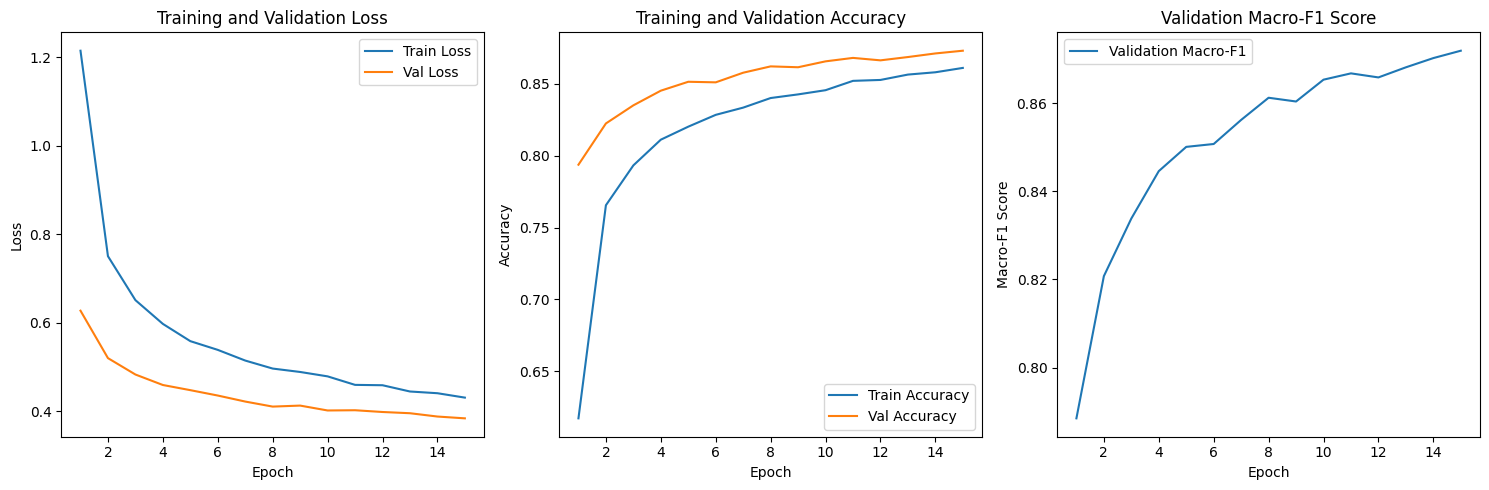

In [74]:
def main():
    print("Loading data...")
    x_train, y_train, x_val, y_val = load_data()
    
    input_size = x_train.shape[1]  # 784 for MNIST
    num_classes = 10

    # # Initialize model1 with default hyperparameters
    # hidden_sizes = [256, 128]
    # learning_rate = 0.001
    
    # print("Initializing model...")
    # model1 = NeuralNetwork(input_size, hidden_sizes, num_classes, learning_rate)
    
    # print("Training model...")
    # metrics = model1.train(x_train, y_train, x_val, y_val, epochs=30, batch_size=128)
    
    # print("Plotting results...")
    # plot_metrics(*metrics)





    # # Initialize model2 with different hyperparameters
    # hidden_sizes = [512, 256, 128]
    # learning_rate = 0.001
    # print("Initializing model...")
    # model2 = NeuralNetwork(input_size, hidden_sizes, num_classes, learning_rate)

    # print("Training model...")
    # metrics = model2.train(x_train, y_train, x_val, y_val, epochs=15, batch_size=64)

    # print("Plotting results...")
    # plot_metrics(*metrics)




    # Initialize model3 with different hidden layer sizes

    hidden_sizes = [512, 256, 128, 64]
    learning_rate = 0.001
    print("Initializing model...")
    model3 = NeuralNetwork(input_size, hidden_sizes, num_classes, learning_rate)

    print("Training model...")
    metrics = model3.train(x_train, y_train, x_val, y_val, epochs=15, batch_size=64)

    print("Plotting results...")
    plot_metrics(*metrics)




if __name__ == "__main__":
    main()